## **Time Series Forecasting of AAL Stock Prices Using ARIMA and Deep Learning Models (2010–2025)**

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import seaborn as sns

from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error, mean_squared_log_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, LSTM, GRU

import yfinance as yf

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

from scipy.signal import periodogram
import warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install yahooquery

  Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl.metadata (13 kB)
Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl (1.6 MB)


### **Loading AAL Stock Data from Yahoo Finance**

In [19]:
from yahooquery import Ticker

aal = Ticker('AAL')
stockdata = aal.history(start='1990-01-01')
open_data = stockdata[['open']].reset_index()[['date', 'open']]
open_data.columns = ['Date', 'Open']
open_data.set_index('Date', inplace=True)
print(open_data.head())

             Open
Date             
2005-09-27 21.050
2005-09-28 19.300
2005-09-29 20.400
2005-09-30 20.260
2005-10-03 20.900


In [20]:
validation_split = 0.25

def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return float(round(rmse,7))

def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return float(round(mape, 7))

def SMAPE(y_true, y_pred):
    smape = 100/len(y_true) * np.sum(2 * np.abs(np.array(y_pred) - np.array(y_true)) / (np.abs(np.array(y_true)) + np.abs(np.array(y_pred))))
    return float(round(smape, 7))

def MSLE(y_true, y_pred):
    rmse = mean_squared_log_error(y_true, y_pred)
    return float(round(rmse, 7))

In [49]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame({"Open":scaler.fit_transform(np.array(open_data['Open']).reshape(len(open_data),1)).reshape(len(open_data),)}, index = open_data.index)
df.head()

,Open
Date,
2005-09-27,0.316
2005-09-28,0.287
2005-09-29,0.305
2005-09-30,0.303
2005-10-03,0.314


In [50]:
df.shape

(5052, 1)

### Statistical Tests

In [51]:
print("\n. BASIC DESCRIPTIVE STATISTICS")
print("-"*80)
print(df['Open'].describe())
print(f"\nSkewness: {df['Open'].skew():.4f}")
print(f"Kurtosis: {df['Open'].kurtosis():.4f}")


1. BASIC DESCRIPTIVE STATISTICS
--------------------------------------------------------------------------------
count   5052.000
mean       0.360
std        0.252
min        0.000
25%        0.156
50%        0.258
75%        0.587
max        1.000
Name: Open, dtype: float64

Skewness: 0.5154
Kurtosis: -1.0514


1. CLASSICAL DECOMPOSITION


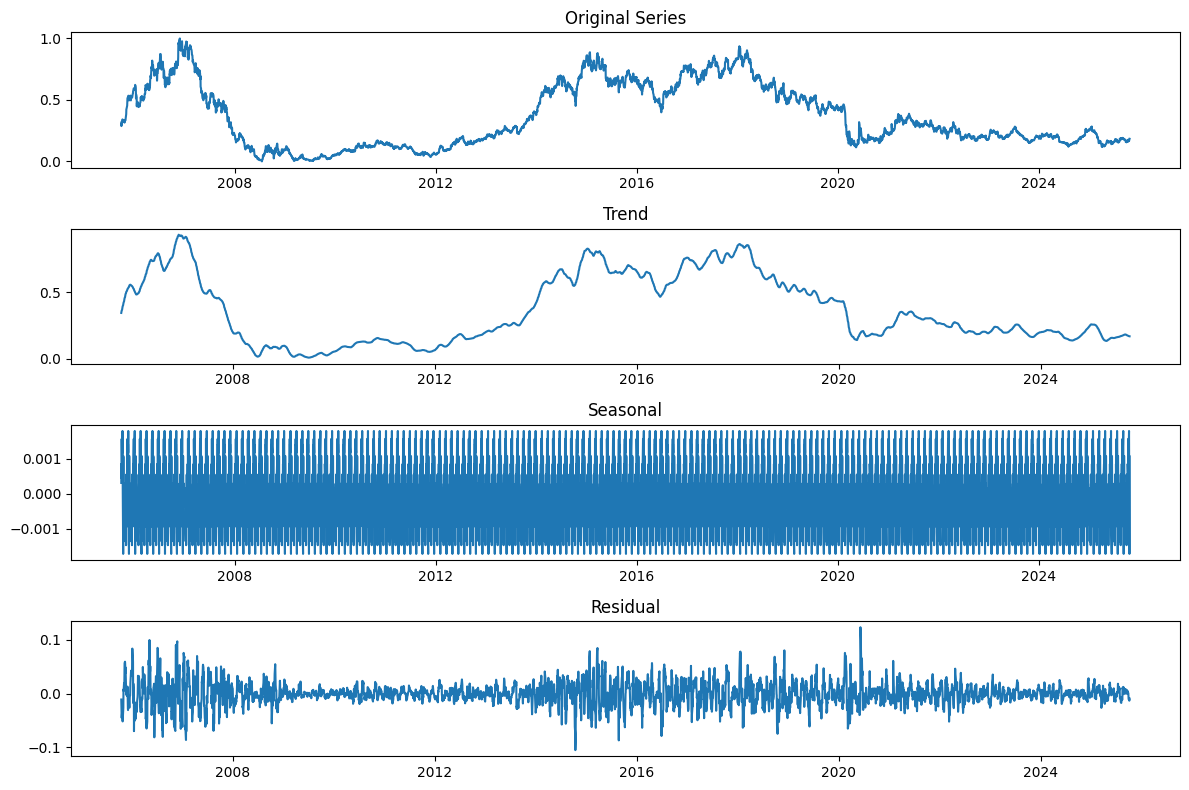

In [61]:
print("1. CLASSICAL DECOMPOSITION")
print("="*50)

plt.figure(figsize=(12, 8))
decomposition = seasonal_decompose(df['Open'], model='additive', period=30)

plt.subplot(411)
plt.plot(df['Open'])
plt.title('Original Series')
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.tight_layout()
plt.savefig('classical_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

In [64]:
# 2. STL DECOMPOSITION
print("\n" + "="*50)
print("2. STL DECOMPOSITION")
print("="*50)

n = len(df)
if n < 14:
    print("⚠ Not enough data points for STL decomposition")
    print("Skipping STL decomposition...")
else:
    # Choose seasonal period
    if n >= 730:
        seasonal = 365
    elif n >= 180:
        seasonal = 31
    elif n >= 60:
        seasonal = 13
    else:
        seasonal = min(13, (n // 2) | 1)  # ensure odd number
    
    print(f"Using seasonal period: {seasonal}")
    
    try:
        from statsmodels.tsa.seasonal import STL
        stl = STL(df['Open'], seasonal=seasonal, robust=True)
        stl_result = stl.fit()
        
        plt.figure(figsize=(12, 8))
        plt.subplot(411)
        plt.plot(df['Open'])
        plt.title('Original Series')
        plt.subplot(412)
        plt.plot(stl_result.trend)
        plt.title('Trend')
        plt.subplot(413)
        plt.plot(stl_result.seasonal)
        plt.title('Seasonal')
        plt.subplot(414)
        plt.plot(stl_result.resid)
        plt.title('Residual')
        plt.tight_layout()
        plt.savefig('stl_decomposition.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"⚠ STL decomposition failed: {e}")
        print("Skipping STL decomposition...")


2. STL DECOMPOSITION
Using seasonal period: 365
⚠ STL decomposition failed: Unable to determine period from endog
Skipping STL decomposition...


In [65]:
# 3. STATIONARITY TESTS
print("\n" + "="*50)
print("3. STATIONARITY TESTS")
print("="*50)

def adf_test(series, name=''):
    """Augmented Dickey-Fuller Test (Weak Stationarity)"""
    result = adfuller(series.dropna())
    print(f'\n{name} - ADF Test Results:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.3f}')
    if result[1] <= 0.05:
        print("✓ Reject null hypothesis - Series is STATIONARY")
    else:
        print("✗ Fail to reject null hypothesis - Series is NON-STATIONARY")
    return result[1] <= 0.05

def kpss_test(series, name=''):
    """KPSS Test (Strict Stationarity)"""
    result = kpss(series.dropna(), regression='c', nlags='auto')
    print(f'\n{name} - KPSS Test Results:')
    print(f'KPSS Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value:.3f}')
    if result[1] >= 0.05:
        print("✓ Fail to reject null hypothesis - Series is STATIONARY")
    else:
        print("✗ Reject null hypothesis - Series is NON-STATIONARY")
    return result[1] >= 0.05

# Test original series
adf_stationary = adf_test(df['Open'], 'Original Series')
kpss_stationary = kpss_test(df['Open'], 'Original Series')


3. STATIONARITY TESTS

Original Series - ADF Test Results:
ADF Statistic: -1.590556
p-value: 0.488336
Critical Values:
   1%: -3.432
   5%: -2.862
   10%: -2.567
✗ Fail to reject null hypothesis - Series is NON-STATIONARY

Original Series - KPSS Test Results:
KPSS Statistic: 1.181745
p-value: 0.010000
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
✗ Reject null hypothesis - Series is NON-STATIONARY


4. MAKING SERIES STATIONARY

Series is non-stationary. Applying differencing...

Differenced Series - ADF Test Results:
ADF Statistic: -15.698558
p-value: 0.000000
Critical Values:
   1%: -3.432
   5%: -2.862
   10%: -2.567
✓ Reject null hypothesis - Series is STATIONARY

Differenced Series - KPSS Test Results:
KPSS Statistic: 0.092515
p-value: 0.100000
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
✓ Fail to reject null hypothesis - Series is STATIONARY


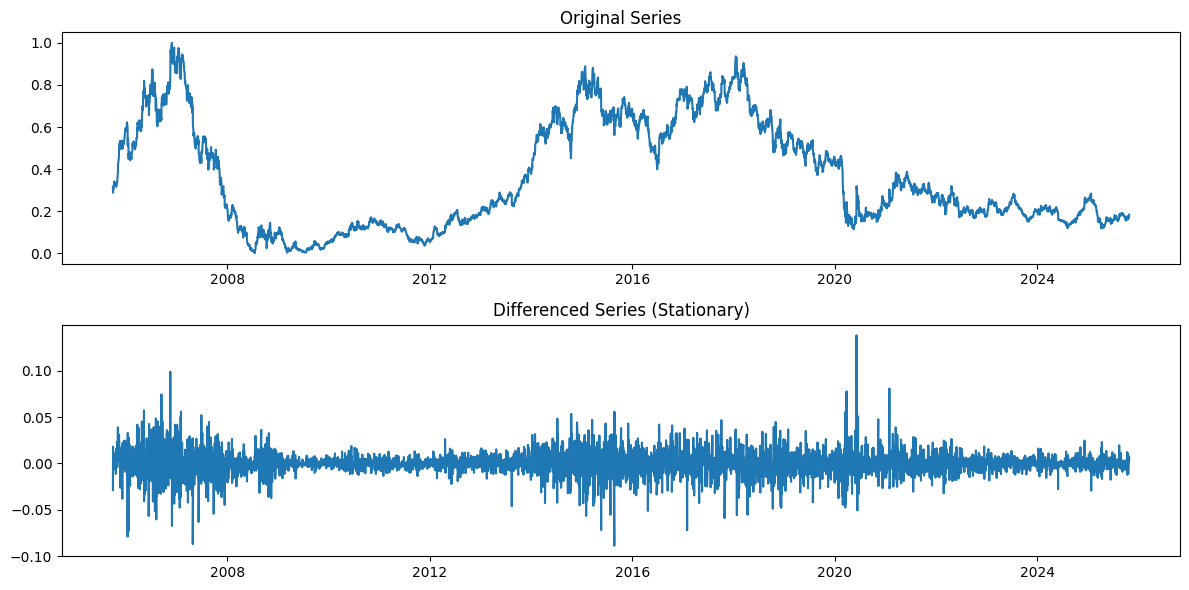

In [66]:
print("4. MAKING SERIES STATIONARY")
print("="*50)

df_stationary = df.copy()

if not adf_stationary or not kpss_stationary:
    print("\nSeries is non-stationary. Applying differencing...")
    df_stationary['Open_diff'] = df['Open'].diff()
    
    # Test differenced series
    adf_test(df_stationary['Open_diff'], 'Differenced Series')
    kpss_test(df_stationary['Open_diff'], 'Differenced Series')
    
    # Plot original vs differenced
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plt.plot(df['Open'])
    plt.title('Original Series')
    plt.subplot(212)
    plt.plot(df_stationary['Open_diff'])
    plt.title('Differenced Series (Stationary)')
    plt.tight_layout()
    plt.savefig('stationarity_transformation.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\nSeries is already stationary!")
    df_stationary['Open_diff'] = df['Open']

In [67]:
print("5. AUTOCORRELATION CHECK")
print("="*50)

from statsmodels.stats.diagnostic import acorr_ljungbox

# Ljung-Box test for autocorrelation
lb_test = acorr_ljungbox(df['Open'].dropna(), lags=[10, 20, 30], return_df=True)
print("\nLjung-Box Test Results:")
print(lb_test)

if (lb_test['lb_pvalue'] < 0.05).any():
    print("\n✓ Significant autocorrelation detected (p-value < 0.05)")
else:
    print("\n✗ No significant autocorrelation detected")

5. AUTOCORRELATION CHECK

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10  49842.175      0.000
20  98466.525      0.000
30 146001.250      0.000

✓ Significant autocorrelation detected (p-value < 0.05)


6. ACF & PACF PLOTS


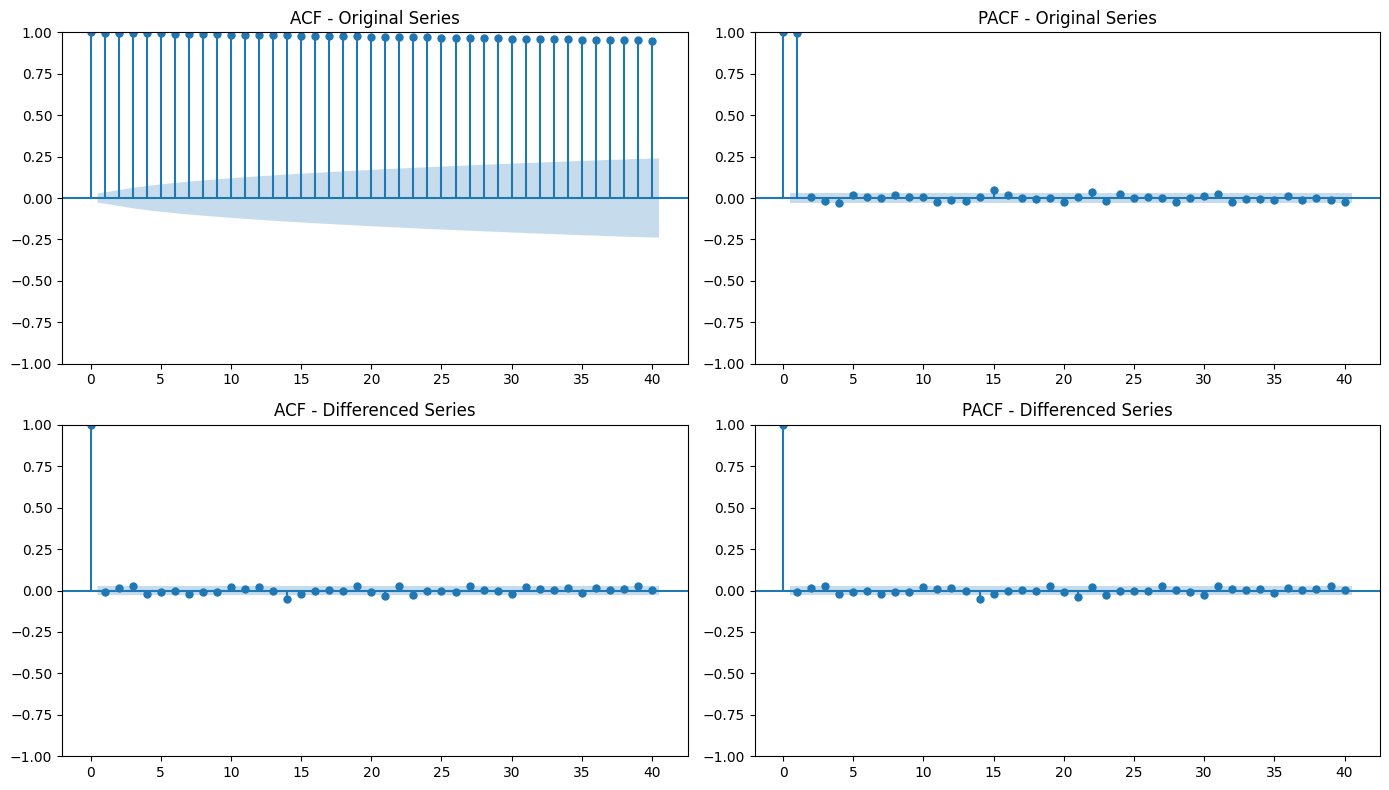

In [68]:
print("6. ACF & PACF PLOTS")
print("="*50)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Original series
plot_acf(df['Open'].dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Original Series')
plot_pacf(df['Open'].dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Original Series')

# Differenced series
plot_acf(df_stationary['Open_diff'].dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF - Differenced Series')
plot_pacf(df_stationary['Open_diff'].dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title('PACF - Differenced Series')

plt.tight_layout()
plt.savefig('acf_pacf_plots.png', dpi=300, bbox_inches='tight')
plt.show()

7. MOVING AVERAGE


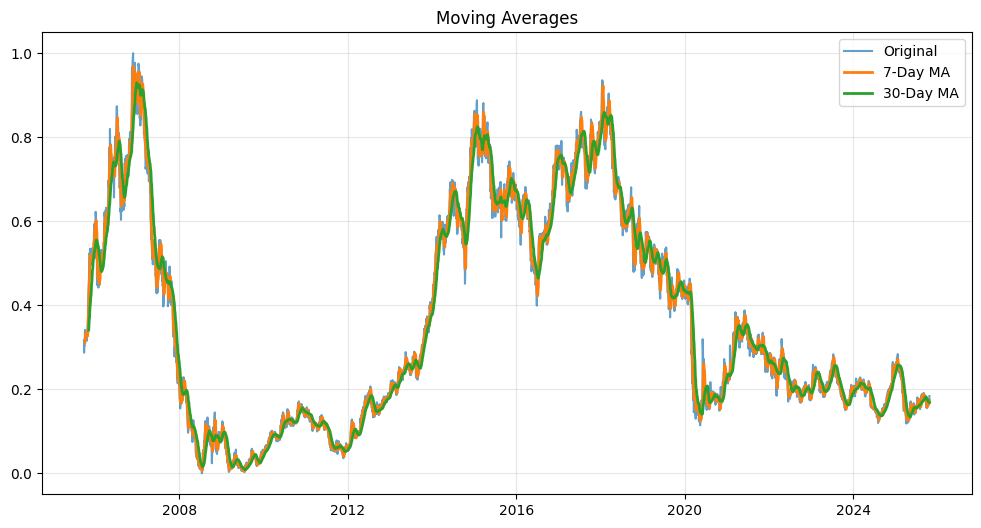

In [69]:
print("7. MOVING AVERAGE")
print("="*50)

df['MA_7'] = df['Open'].rolling(window=7).mean()
df['MA_30'] = df['Open'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Open'], label='Original', alpha=0.7)
plt.plot(df['MA_7'], label='7-Day MA', linewidth=2)
plt.plot(df['MA_30'], label='30-Day MA', linewidth=2)
plt.title('Moving Averages')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('moving_average.png', dpi=300, bbox_inches='tight')
plt.show()

8. ARIMA MODEL

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                 4041
Model:                 ARIMA(2, 1, 2)   Log Likelihood               11552.147
Date:                Sun, 26 Oct 2025   AIC                         -23094.293
Time:                        01:05:29   BIC                         -23062.773
Sample:                             0   HQIC                        -23083.126
                               - 4041                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3402      0.563     -0.604      0.546      -1.444       0.763
ar.L2         -0.4671      0.322     -1.449      0.147      -1.099       0.165
ma.L1          

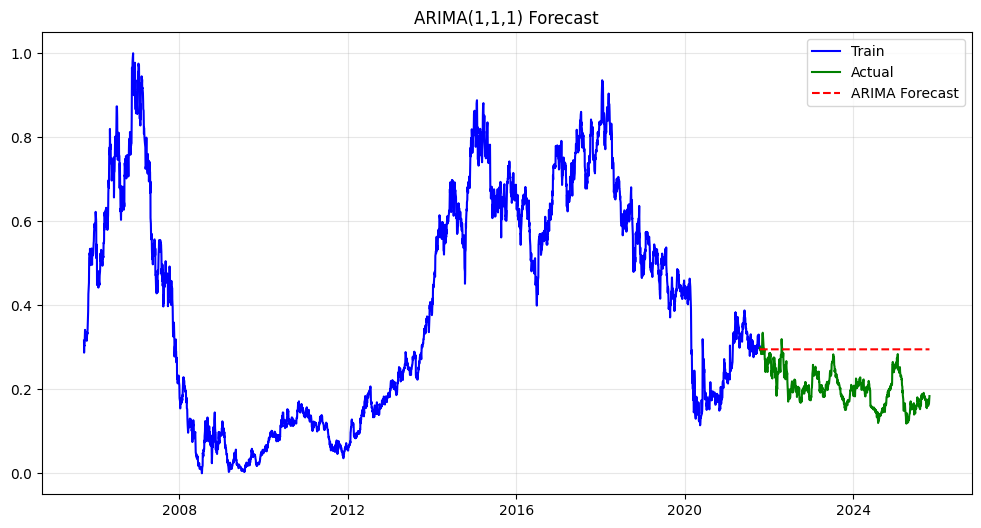

In [88]:
print("8. ARIMA MODEL")
print("="*50)

from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (p,d,q) - using simple parameters
# p: AR order, d: differencing order, q: MA order
try:
    arima_model = ARIMA(train, order=(2, 1, 2))
    arima_fit = arima_model.fit()
    
    print("\nARIMA Model Summary:")
    print(arima_fit.summary())
    
    # Forecast
    arima_forecast = arima_fit.forecast(steps=len(test))
    
    # Calculate metrics
    arima_mse = mean_squared_error(test, arima_forecast)
    arima_rmse = np.sqrt(arima_mse)
    arima_mae = mean_absolute_error(test, arima_forecast)
    arima_mape = np.mean(np.abs((test - arima_forecast) / test)) * 100
    
    print(f"\nARIMA Evaluation Metrics:")
    print(f"MSE: {arima_mse:.4f}")
    print(f"RMSE: {arima_rmse:.4f}")
    print(f"MAE: {arima_mae:.4f}")
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Actual', color='green')
    plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='red', linestyle='--')
    plt.title('ARIMA(2,1,2) Forecast')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('arima_forecast.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except Exception as e:
    print(f"⚠ ARIMA model failed: {e}")

9. SARIMA MODEL (Seasonal ARIMA)

SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                               Open   No. Observations:                 4041
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood               11480.137
Date:                            Sun, 26 Oct 2025   AIC                         -22946.274
Time:                                    01:05:55   BIC                         -22902.167
Sample:                                         0   HQIC                        -22930.645
                                           - 4041                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0114      0.715      0.016      0.987    

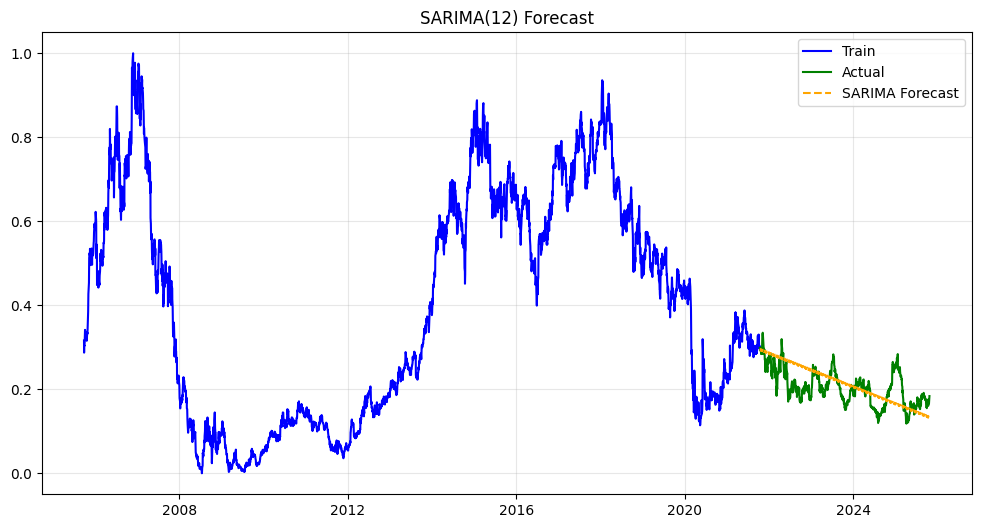

In [89]:
print("9. SARIMA MODEL (Seasonal ARIMA)")
print("="*50)

from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA parameters: (p,d,q) x (P,D,Q,s)
# s: seasonal period
if n >= 30:
    seasonal_period = min(12, n // 10)
else:
    seasonal_period = 7

try:
    sarima_model = SARIMAX(train, 
                           order=(2, 1, 1),
                           seasonal_order=(2, 1, 1, seasonal_period))
    sarima_fit = sarima_model.fit(disp=False)
    
    print("\nSARIMA Model Summary:")
    print(sarima_fit.summary())
    
    # Forecast
    sarima_forecast = sarima_fit.forecast(steps=len(test))
    
    # Calculate metrics
    sarima_mse = mean_squared_error(test, sarima_forecast)
    sarima_rmse = np.sqrt(sarima_mse)
    sarima_mae = mean_absolute_error(test, sarima_forecast)
    sarima_mape = np.mean(np.abs((test - sarima_forecast) / test)) * 100
    
    print(f"\nSARIMA Evaluation Metrics:")
    print(f"MSE: {sarima_mse:.4f}")
    print(f"RMSE: {sarima_rmse:.4f}")
    print(f"MAE: {sarima_mae:.4f}")
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Actual', color='green')
    plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='orange', linestyle='--')
    plt.title(f'SARIMA({seasonal_period}) Forecast')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('sarima_forecast.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except Exception as e:
    print(f"⚠ SARIMA model failed: {e}")

10. SARIMAX MODEL (SARIMA with eXogenous variables)

Fitting SARIMAX(1,1,1)x(1,1,1,12) model with exogenous variables...
Exogenous variables: time_trend, ma_7

SARIMAX Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                               Open   No. Observations:                 4041
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               11980.605
Date:                            Sun, 26 Oct 2025   AIC                         -23947.209
Time:                                    01:06:50   BIC                         -23903.102
Sample:                                         0   HQIC                        -23931.580
                                           - 4041                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------

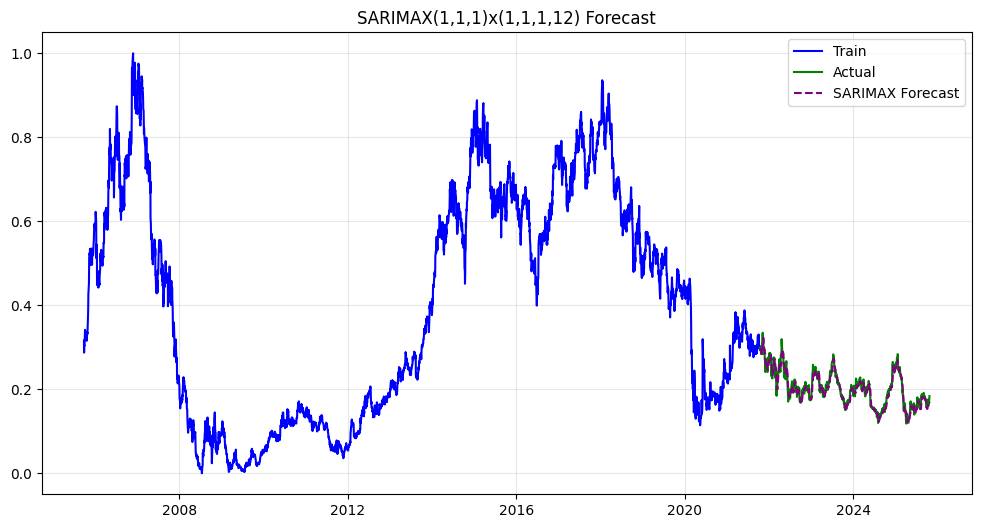

In [90]:
print("10. SARIMAX MODEL (SARIMA with eXogenous variables)")
print("="*50)

try:
    # Create exogenous variables (example: time trend and moving average)
    df_full = df.copy()
    df_full['time_trend'] = np.arange(len(df_full))
    df_full['ma_7'] = df_full['Open'].rolling(window=7, min_periods=1).mean()
    
    # Split exogenous variables
    exog_train = df_full[['time_trend', 'ma_7']][:train_size]
    exog_test = df_full[['time_trend', 'ma_7']][train_size:]
    
    print(f"\nFitting SARIMAX(1,1,1)x(1,1,1,{seasonal_period}) model with exogenous variables...")
    print("Exogenous variables: time_trend, ma_7")
    
    sarimax_model = SARIMAX(train,
                            exog=exog_train,
                            order=(1, 1, 1),
                            seasonal_order=(1, 1, 1, seasonal_period))
    sarimax_fit = sarimax_model.fit(disp=False)
    
    print("\nSARIMAX Model Summary:")
    print(sarimax_fit.summary())
    
    # Forecast
    sarimax_forecast = sarimax_fit.forecast(steps=len(test), exog=exog_test)
    
    # Calculate metrics
    sarimax_mse = mean_squared_error(test, sarimax_forecast)
    sarimax_rmse = np.sqrt(sarimax_mse)
    sarimax_mae = mean_absolute_error(test, sarimax_forecast)
    sarimax_mape = np.mean(np.abs((test - sarimax_forecast) / test)) * 100
    
    print(f"\nSARIMAX Evaluation Metrics:")
    print(f"MSE: {sarimax_mse:.4f}")
    print(f"RMSE: {sarimax_rmse:.4f}")
    print(f"MAE: {sarimax_mae:.4f}")
    print(f"MAPE: {sarimax_mape:.2f}%")
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Actual', color='green')
    plt.plot(test.index, sarimax_forecast, label='SARIMAX Forecast', color='purple', linestyle='--')
    plt.title(f'SARIMAX(1,1,1)x(1,1,1,{seasonal_period}) Forecast')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('sarimax_forecast.png', dpi=300, bbox_inches='tight')
    plt.show()
    
except Exception as e:
    print(f"⚠ SARIMAX model failed: {e}")

11. MODEL COMPARISON

Model Performance Comparison:
         Model  RMSE   MAE
Moving Average 0.010 0.007
         ARIMA 0.100 0.092
        SARIMA 0.041 0.033
       SARIMAX 0.010 0.008


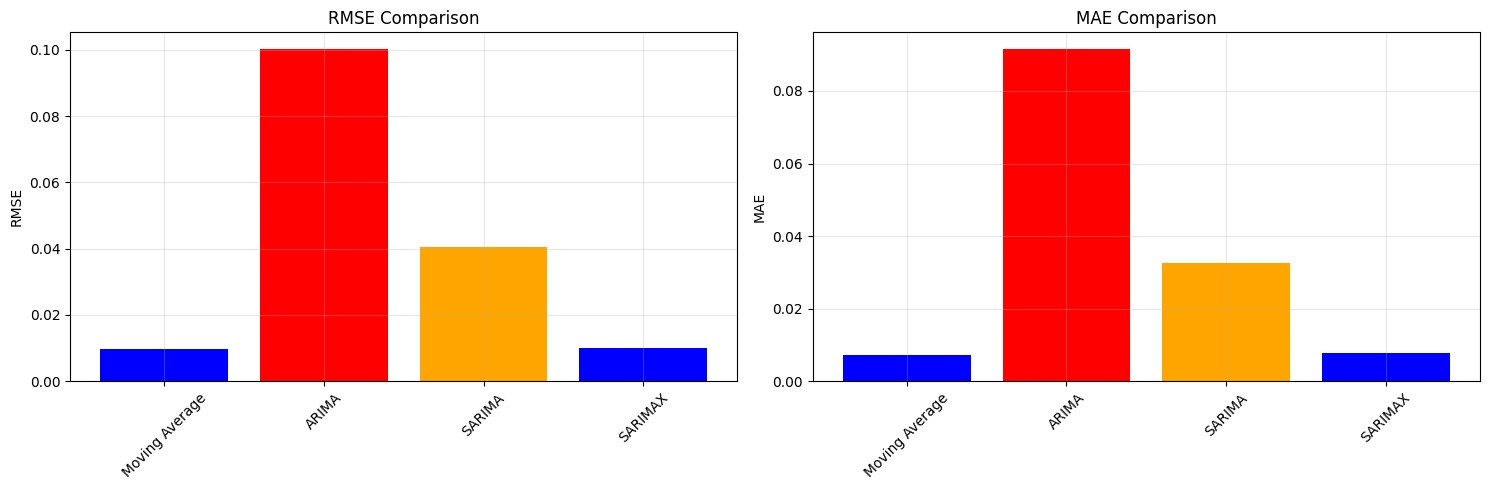

In [91]:
print("11. MODEL COMPARISON")
print("="*50)

comparison_data = {
    'Model': ['Moving Average', 'ARIMA', 'SARIMA', 'SARIMAX'],
    'RMSE': [rmse, 
             arima_rmse if 'arima_rmse' in locals() else np.nan,
             sarima_rmse if 'sarima_rmse' in locals() else np.nan,
             sarimax_rmse if 'sarimax_rmse' in locals() else np.nan],
    'MAE': [mae,
            arima_mae if 'arima_mae' in locals() else np.nan,
            sarima_mae if 'sarima_mae' in locals() else np.nan,
            sarimax_mae if 'sarimax_mae' in locals() else np.nan]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for idx, metric in enumerate(['RMSE', 'MAE']):
    axes[idx].bar(comparison_df['Model'], comparison_df[metric], color=['blue', 'red', 'orange'])
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].set_ylabel(metric)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### **RNN Model**

In [92]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

In [93]:
train_data = df_train.values
test_data = df_test.values

In [94]:
x_train = []
y_train = []

for i in range(60, len(train_data)):

    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [95]:
# ✅ Split training into training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

In [96]:
from tensorflow.keras.callbacks import EarlyStopping

# Build the RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(Dropout(0.2))
rnn_model.add(SimpleRNN(32, return_sequences=False))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(16, activation="relu"))
rnn_model.add(Dense(1))

rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# ✅ Add EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = rnn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0614 - val_loss: 0.0051
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0139 - val_loss: 0.0031
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0075 - val_loss: 0.0028
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0077 - val_loss: 0.0032
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0058 - val_loss: 0.0029
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0054 - val_loss: 0.0020
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step

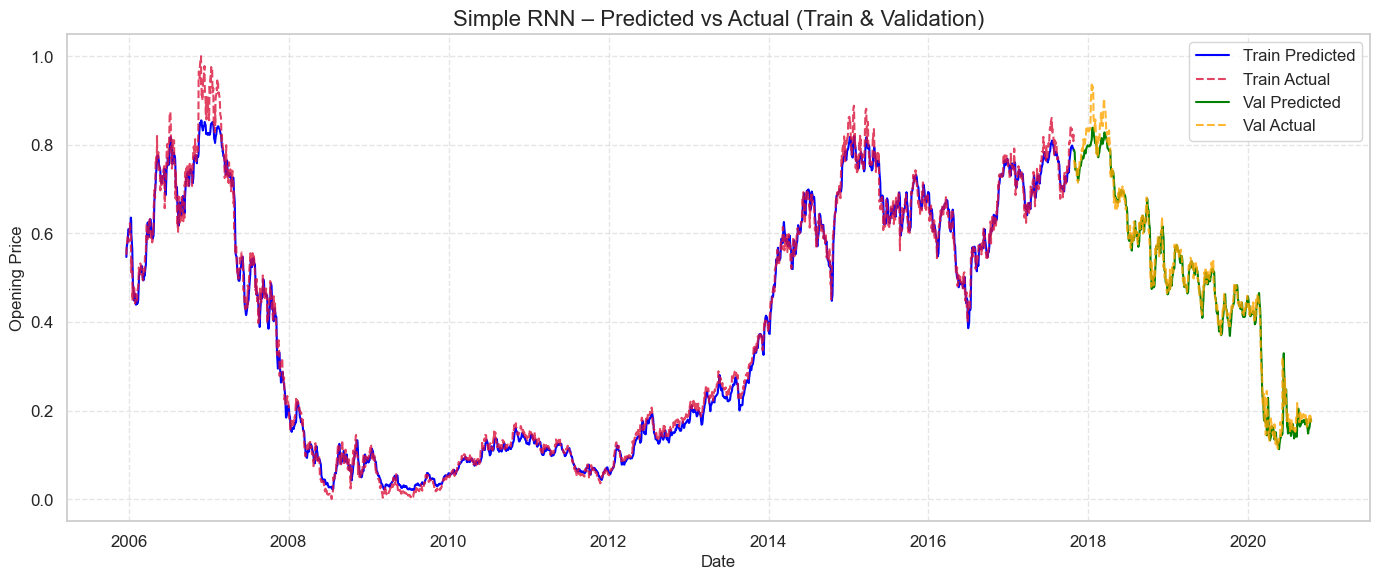

In [97]:
# ----------------------------
# Training predictions
# ----------------------------
rnn_train_predictions = rnn_model.predict(x_train, verbose=0)

# Align dates with x_train (since validation data has been split off)
train_dates = df_train.index[60:60+len(x_train)]  

rnn_train_df = pd.DataFrame({
    'Date': train_dates,
    'RNN_Predicted': rnn_train_predictions.flatten(),
    'Actual': y_train.flatten()
})
rnn_train_df.set_index('Date', inplace=True)

# ----------------------------
# Validation predictions
# ----------------------------
rnn_val_predictions = rnn_model.predict(x_val, verbose=0)

val_dates = df_train.index[60+len(x_train): 60+len(x_train)+len(x_val)]

rnn_val_df = pd.DataFrame({
    'Date': val_dates,
    'RNN_Predicted': rnn_val_predictions.flatten(),
    'Actual': y_val.flatten()
})
rnn_val_df.set_index('Date', inplace=True)

# ----------------------------
# Plotting
# ----------------------------
sns.set(style='whitegrid', font_scale=1.1)
plt.figure(figsize=(14, 6))

plt.plot(rnn_train_df['RNN_Predicted'], label='Train Predicted', color='blue', linewidth=1.5)
plt.plot(rnn_train_df['Actual'], label='Train Actual', color='crimson', linestyle='--', linewidth=1.5, alpha=0.8)

plt.plot(rnn_val_df['RNN_Predicted'], label='Val Predicted', color='green', linewidth=1.5)
plt.plot(rnn_val_df['Actual'], label='Val Actual', color='orange', linestyle='--', linewidth=1.5, alpha=0.8)

plt.title('Simple RNN – Predicted vs Actual (Train & Validation)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Opening Price', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Detected 3 features in test data. Using only first feature for forecasting.


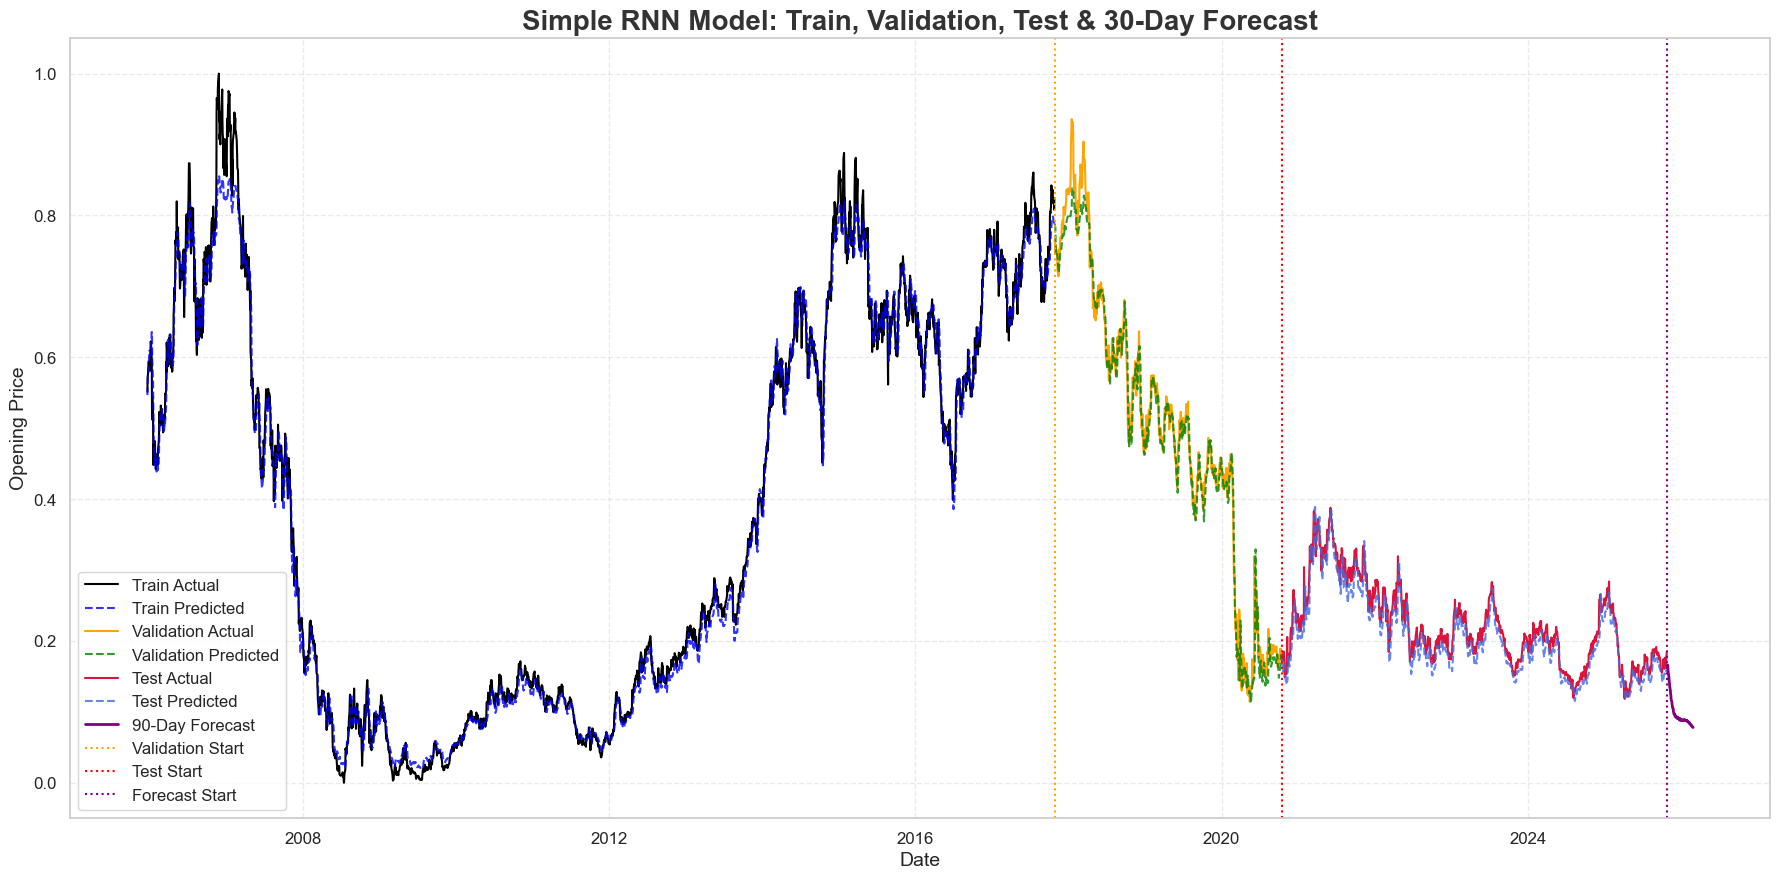

In [102]:
# -----------------------------
# 1. TRAIN & VALIDATION PREDICTIONS
# -----------------------------
train_predictions = rnn_model.predict(x_train, verbose=0)
val_predictions = rnn_model.predict(x_val, verbose=0)

train_dates = df_train.index[60:60+len(x_train)]
val_dates = df_train.index[60+len(x_train):60+len(x_train)+len(x_val)]

train_df_plot = pd.DataFrame({
    "Date": train_dates,
    "Predicted": train_predictions.flatten(),
    "Actual": y_train.flatten()
}).set_index("Date")

val_df_plot = pd.DataFrame({
    "Date": val_dates,
    "Predicted": val_predictions.flatten(),
    "Actual": y_val.flatten()
}).set_index("Date")


# -----------------------------
# 2. TEST PREDICTIONS
# -----------------------------
full_test_data = np.concatenate((train_data[-60:], test_data), axis=0)

x_test, y_test = [], []
for i in range(60, len(full_test_data)):
    x_test.append(full_test_data[i-60:i, 0])
    y_test.append(full_test_data[i, 0])

x_test = np.array(x_test).reshape(-1, 60, 1)
y_test = np.array(y_test)

test_predictions = rnn_model.predict(x_test, verbose=0)

test_dates = df_test.index
test_df_plot = pd.DataFrame({
    "Date": test_dates,
    "Predicted": test_predictions.flatten(),
    "Actual": y_test.flatten()
}).set_index("Date")


# -----------------------------
# -----------------------------
# 3. 90-DAY FORECAST (FINAL FIX)
# -----------------------------
window_size = 60

# Detect number of features
if len(full_test_data.shape) == 1:
    n_features = 1
elif len(full_test_data.shape) == 2:
    n_features = full_test_data.shape[1]
else:
    raise ValueError("Unexpected shape for full_test_data")

# If model was trained with only one feature (e.g. 'Open'), use that column
if n_features > 1:
    print(f"Detected {n_features} features in test data. Using only first feature for forecasting.")
    full_test_data = full_test_data[:, 0].reshape(-1, 1)
    n_features = 1

# Now the last window matches the model’s training shape
last_window = full_test_data[-window_size:].reshape(1, window_size, n_features)

forecast = []
for _ in range(90):
    next_pred = rnn_model.predict(last_window, verbose=0)[0, 0]
    forecast.append(next_pred)

    # Shift window with new prediction
    next_input = np.append(last_window[:, 1:, :], [[[next_pred]]], axis=1)
    last_window = next_input

# Create 90 business-day forecast
forecast_dates = pd.date_range(
    start=df_test.index[-1] + pd.Timedelta(days=1),
    periods=90,
    freq="B"
)

forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "Forecast": forecast
}).set_index("Date")


# -----------------------------
# 4. PLOTTING ALL TOGETHER
# -----------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(18, 9))
plt.title('Simple RNN Model: Train, Validation, Test & 30-Day Forecast', fontsize=20, fontweight='bold', color='#333333')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Opening Price', fontsize=14)

# Train
plt.plot(train_df_plot['Actual'], label='Train Actual', color='black', linewidth=1.5)
plt.plot(train_df_plot['Predicted'], label='Train Predicted', color='blue', linestyle='--', alpha=0.8)

# Validation
plt.plot(val_df_plot['Actual'], label='Validation Actual', color='orange', linewidth=1.5)
plt.plot(val_df_plot['Predicted'], label='Validation Predicted', color='green', linestyle='--', alpha=0.8)

# Test
plt.plot(test_df_plot['Actual'], label='Test Actual', color='crimson', linewidth=1.5)
plt.plot(test_df_plot['Predicted'], label='Test Predicted', color='royalblue', linestyle='--', alpha=0.8)

# Forecast
plt.plot(forecast_df['Forecast'], label='90-Day Forecast', color='purple', linewidth=2)

# Markers
plt.axvline(x=val_df_plot.index[0], color='orange', linestyle=':', label='Validation Start')
plt.axvline(x=test_df_plot.index[0], color='red', linestyle=':', label='Test Start')
plt.axvline(x=forecast_df.index[0], color='purple', linestyle=':', label='Forecast Start')

plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [99]:
print(full_test_data.shape)


(1323, 3)


In [103]:
rmse_rnn = RMSE(y_test, test_predictions.flatten())
mape_rnn = MAPE(y_test, test_predictions.flatten())
smape_rnn = SMAPE(y_test, test_predictions.flatten())
msle_rnn = MSLE(y_test, test_predictions.flatten())

metrics_rnn = {
    "RMSE_RNN": rmse_rnn,
    "MAPE_RNN": mape_rnn,
    "SMAPE_RNN": smape_rnn,
    "MSLE_RNN": msle_rnn
}

metrics_rnn

{'RMSE_RNN': 0.0183919,
 'MAPE_RNN': 7.0004825,
 'SMAPE_RNN': 7.3263815,
 'MSLE_RNN': 0.0002251}

### **LSTM Model** 

In [104]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

In [105]:
train_data = df_train.values
test_data = df_test.values

In [106]:
x_train = []
y_train = []

for i in range(60, len(train_data)):

    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [107]:
# ✅ Split training into training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

In [108]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(16, activation="relu"))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# ✅ EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_lstm = lstm_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 0.0467 - val_loss: 0.0058
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0019 - val_loss: 0.0029
Epoch 12/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step

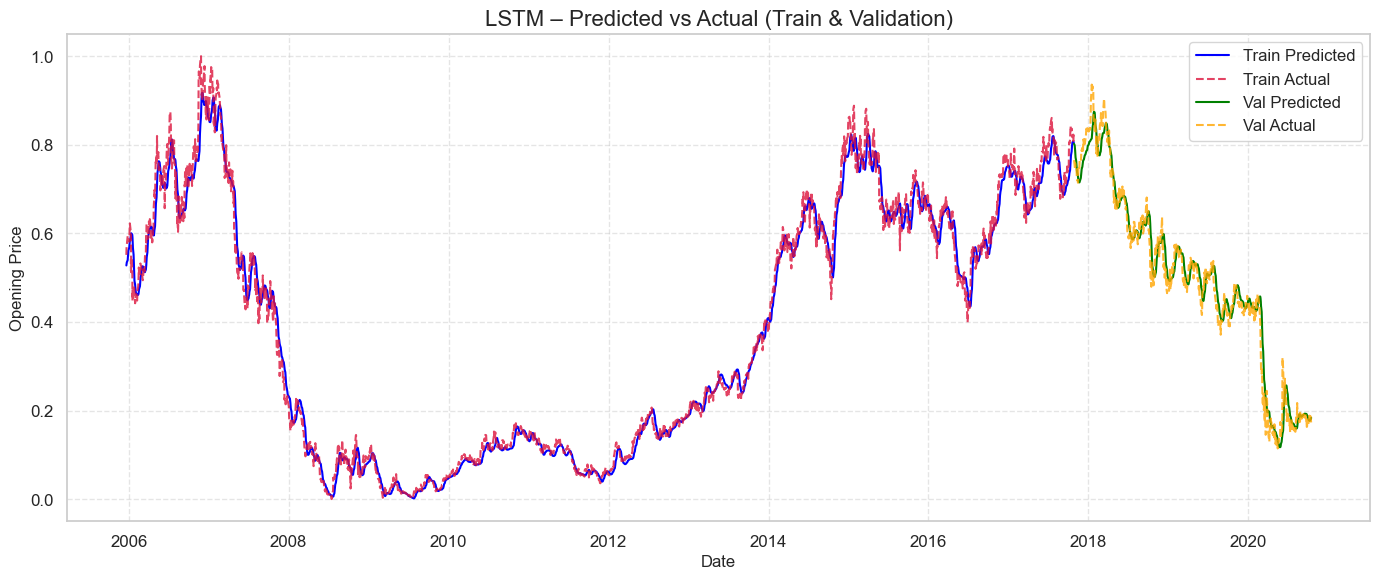

In [109]:
# ----------------------------
# Training predictions
# ----------------------------
lstm_train_predictions = lstm_model.predict(x_train, verbose=0)

# Align dates with x_train (since validation data has been split off)
train_dates = df_train.index[60:60+len(x_train)]  

lstm_train_df = pd.DataFrame({
    'Date': train_dates,
    'lstm_Predicted': lstm_train_predictions.flatten(),
    'Actual': y_train.flatten()
})
lstm_train_df.set_index('Date', inplace=True)

# ----------------------------
# Validation predictions
# ----------------------------
lstm_val_predictions = lstm_model.predict(x_val, verbose=0)

val_dates = df_train.index[60+len(x_train): 60+len(x_train)+len(x_val)]

lstm_val_df = pd.DataFrame({
    'Date': val_dates,
    'lstm_Predicted': lstm_val_predictions.flatten(),
    'Actual': y_val.flatten()
})
lstm_val_df.set_index('Date', inplace=True)

# ----------------------------
# Plotting
# ----------------------------
sns.set(style='whitegrid', font_scale=1.1)
plt.figure(figsize=(14, 6))

plt.plot(lstm_train_df['lstm_Predicted'], label='Train Predicted', color='blue', linewidth=1.5)
plt.plot(lstm_train_df['Actual'], label='Train Actual', color='crimson', linestyle='--', linewidth=1.5, alpha=0.8)

plt.plot(lstm_val_df['lstm_Predicted'], label='Val Predicted', color='green', linewidth=1.5)
plt.plot(lstm_val_df['Actual'], label='Val Actual', color='orange', linestyle='--', linewidth=1.5, alpha=0.8)

plt.title('LSTM – Predicted vs Actual (Train & Validation)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Opening Price', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Detected 3 features in test data. Using only first feature for forecasting.


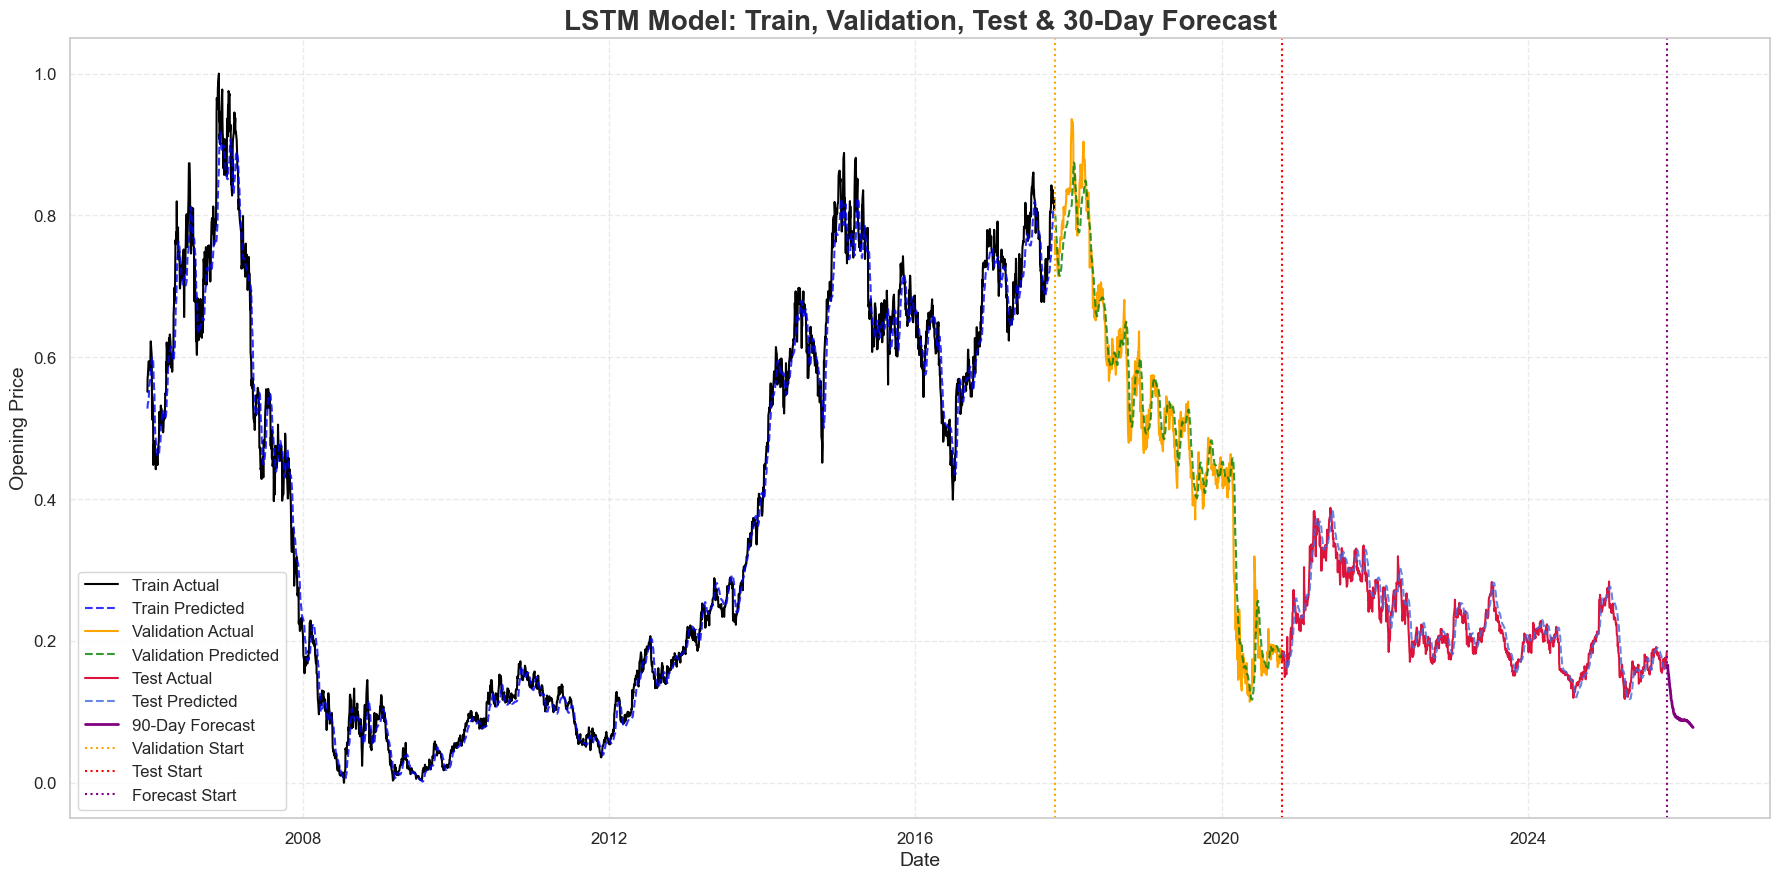

In [110]:
# -----------------------------
# 1. TRAIN & VALIDATION PREDICTIONS
# -----------------------------
train_predictions = lstm_model.predict(x_train, verbose=0)
val_predictions = lstm_model.predict(x_val, verbose=0)

train_dates = df_train.index[60:60+len(x_train)]
val_dates = df_train.index[60+len(x_train):60+len(x_train)+len(x_val)]

train_df_plot = pd.DataFrame({
    "Date": train_dates,
    "Predicted": train_predictions.flatten(),
    "Actual": y_train.flatten()
}).set_index("Date")

val_df_plot = pd.DataFrame({
    "Date": val_dates,
    "Predicted": val_predictions.flatten(),
    "Actual": y_val.flatten()
}).set_index("Date")


# -----------------------------
# 2. TEST PREDICTIONS
# -----------------------------
full_test_data = np.concatenate((train_data[-60:], test_data), axis=0)

x_test, y_test = [], []
for i in range(60, len(full_test_data)):
    x_test.append(full_test_data[i-60:i, 0])
    y_test.append(full_test_data[i, 0])

x_test = np.array(x_test).reshape(-1, 60, 1)
y_test = np.array(y_test)

test_predictions = lstm_model.predict(x_test, verbose=0)

test_dates = df_test.index
test_df_plot = pd.DataFrame({
    "Date": test_dates,
    "Predicted": test_predictions.flatten(),
    "Actual": y_test.flatten()
}).set_index("Date")


# -----------------------------
# -----------------------------
# 3. 90-DAY FORECAST (FINAL FIX)
# -----------------------------
window_size = 60

# Detect number of features
if len(full_test_data.shape) == 1:
    n_features = 1
elif len(full_test_data.shape) == 2:
    n_features = full_test_data.shape[1]
else:
    raise ValueError("Unexpected shape for full_test_data")

# If model was trained with only one feature (e.g. 'Open'), use that column
if n_features > 1:
    print(f"Detected {n_features} features in test data. Using only first feature for forecasting.")
    full_test_data = full_test_data[:, 0].reshape(-1, 1)
    n_features = 1

# Now the last window matches the model’s training shape
last_window = full_test_data[-window_size:].reshape(1, window_size, n_features)

forecast = []
for _ in range(90):
    next_pred = rnn_model.predict(last_window, verbose=0)[0, 0]
    forecast.append(next_pred)

    # Shift window with new prediction
    next_input = np.append(last_window[:, 1:, :], [[[next_pred]]], axis=1)
    last_window = next_input

# Create 90 business-day forecast
forecast_dates = pd.date_range(
    start=df_test.index[-1] + pd.Timedelta(days=1),
    periods=90,
    freq="B"
)

forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "Forecast": forecast
}).set_index("Date")

# -----------------------------
# 4. PLOTTING ALL TOGETHER
# -----------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(18, 9))
plt.title('LSTM Model: Train, Validation, Test & 30-Day Forecast', fontsize=20, fontweight='bold', color='#333333')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Opening Price', fontsize=14)

# Train
plt.plot(train_df_plot['Actual'], label='Train Actual', color='black', linewidth=1.5)
plt.plot(train_df_plot['Predicted'], label='Train Predicted', color='blue', linestyle='--', alpha=0.8)

# Validation
plt.plot(val_df_plot['Actual'], label='Validation Actual', color='orange', linewidth=1.5)
plt.plot(val_df_plot['Predicted'], label='Validation Predicted', color='green', linestyle='--', alpha=0.8)

# Test
plt.plot(test_df_plot['Actual'], label='Test Actual', color='crimson', linewidth=1.5)
plt.plot(test_df_plot['Predicted'], label='Test Predicted', color='royalblue', linestyle='--', alpha=0.8)

# Forecast
plt.plot(forecast_df['Forecast'], label='90-Day Forecast', color='purple', linewidth=2)

# Markers
plt.axvline(x=val_df_plot.index[0], color='orange', linestyle=':', label='Validation Start')
plt.axvline(x=test_df_plot.index[0], color='red', linestyle=':', label='Test Start')
plt.axvline(x=forecast_df.index[0], color='purple', linestyle=':', label='Forecast Start')

plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [111]:
rmse_LSTM = RMSE(y_test, test_predictions.flatten())
mape_LSTM = MAPE(y_test, test_predictions.flatten())
smape_LSTM = SMAPE(y_test, test_predictions.flatten())
msle_LSTM = MSLE(y_test, test_predictions.flatten())

Metrics = {
    "RMSE_LSTM": rmse_LSTM, 
    "MAPE_LSTM": mape_LSTM, 
    "SMAPE_LSTM": smape_LSTM, 
    "MSLE_LSTM": msle_LSTM
}

Metrics

{'RMSE_LSTM': 0.0187932,
 'MAPE_LSTM': 6.7170082,
 'SMAPE_LSTM': 6.5402075,
 'MSLE_LSTM': 0.0002305}

### **GRU Model**

In [112]:
trainfrac = 0.75
df_train, df_test = train_test_split(df, train_size=trainfrac, shuffle=False, stratify=None)

In [113]:
train_data = df_train.values
test_data = df_test.values

In [114]:
x_train = []
y_train = []

for i in range(60, len(train_data)):

    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [115]:
# ✅ Split training into training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

In [116]:
# Build the GRU model
gru_model = Sequential()
gru_model.add(GRU(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(32, return_sequences=False))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(16, activation="relu"))
gru_model.add(Dense(1))

gru_model.compile(optimizer='adam', loss='mean_squared_error')

# ✅ EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_gru = gru_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 109ms/step - loss: 0.0302 - val_loss: 9.9818e-04
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 0.0030 - val_loss: 7.3107e-04
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0023 - val_loss: 8.9085e-04
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0021 - val_loss: 9.0686e-04
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.0018 - val_loss: 9.2728e-04
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 0.0017 - val_loss: 5.8039e-04
Epoch 9/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 0.0017 - val_loss: 5.2605e-04
Epoch 10/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - loss: 0.0014 - val_loss: 5.7960e-04
Epoch 11/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 12/100
94/9

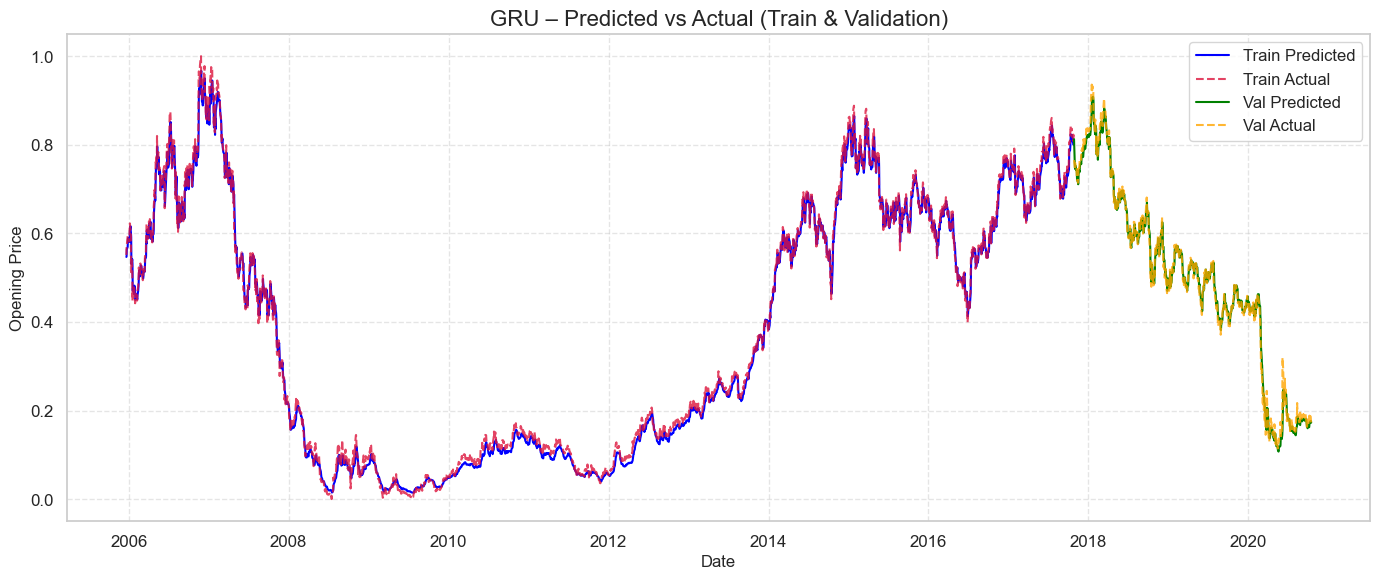

In [117]:
# ----------------------------
# Training predictions
# ----------------------------
gru_train_predictions = gru_model.predict(x_train, verbose=0)

# Align dates with x_train (since validation data has been split off)
train_dates = df_train.index[60:60+len(x_train)]  

gru_train_df = pd.DataFrame({
    'Date': train_dates,
    'gru_Predicted': gru_train_predictions.flatten(),
    'Actual': y_train.flatten()
})
gru_train_df.set_index('Date', inplace=True)

# ----------------------------
# Validation predictions
# ----------------------------
gru_val_predictions = gru_model.predict(x_val, verbose=0)

val_dates = df_train.index[60+len(x_train): 60+len(x_train)+len(x_val)]

gru_val_df = pd.DataFrame({
    'Date': val_dates,
    'gru_Predicted': gru_val_predictions.flatten(),
    'Actual': y_val.flatten()
})
gru_val_df.set_index('Date', inplace=True)

# ----------------------------
# Plotting
# ----------------------------
sns.set(style='whitegrid', font_scale=1.1)
plt.figure(figsize=(14, 6))

plt.plot(gru_train_df['gru_Predicted'], label='Train Predicted', color='blue', linewidth=1.5)
plt.plot(gru_train_df['Actual'], label='Train Actual', color='crimson', linestyle='--', linewidth=1.5, alpha=0.8)

plt.plot(gru_val_df['gru_Predicted'], label='Val Predicted', color='green', linewidth=1.5)
plt.plot(gru_val_df['Actual'], label='Val Actual', color='orange', linestyle='--', linewidth=1.5, alpha=0.8)

plt.title('GRU – Predicted vs Actual (Train & Validation)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Opening Price', fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Detected 3 features in test data. Using only first feature for forecasting.


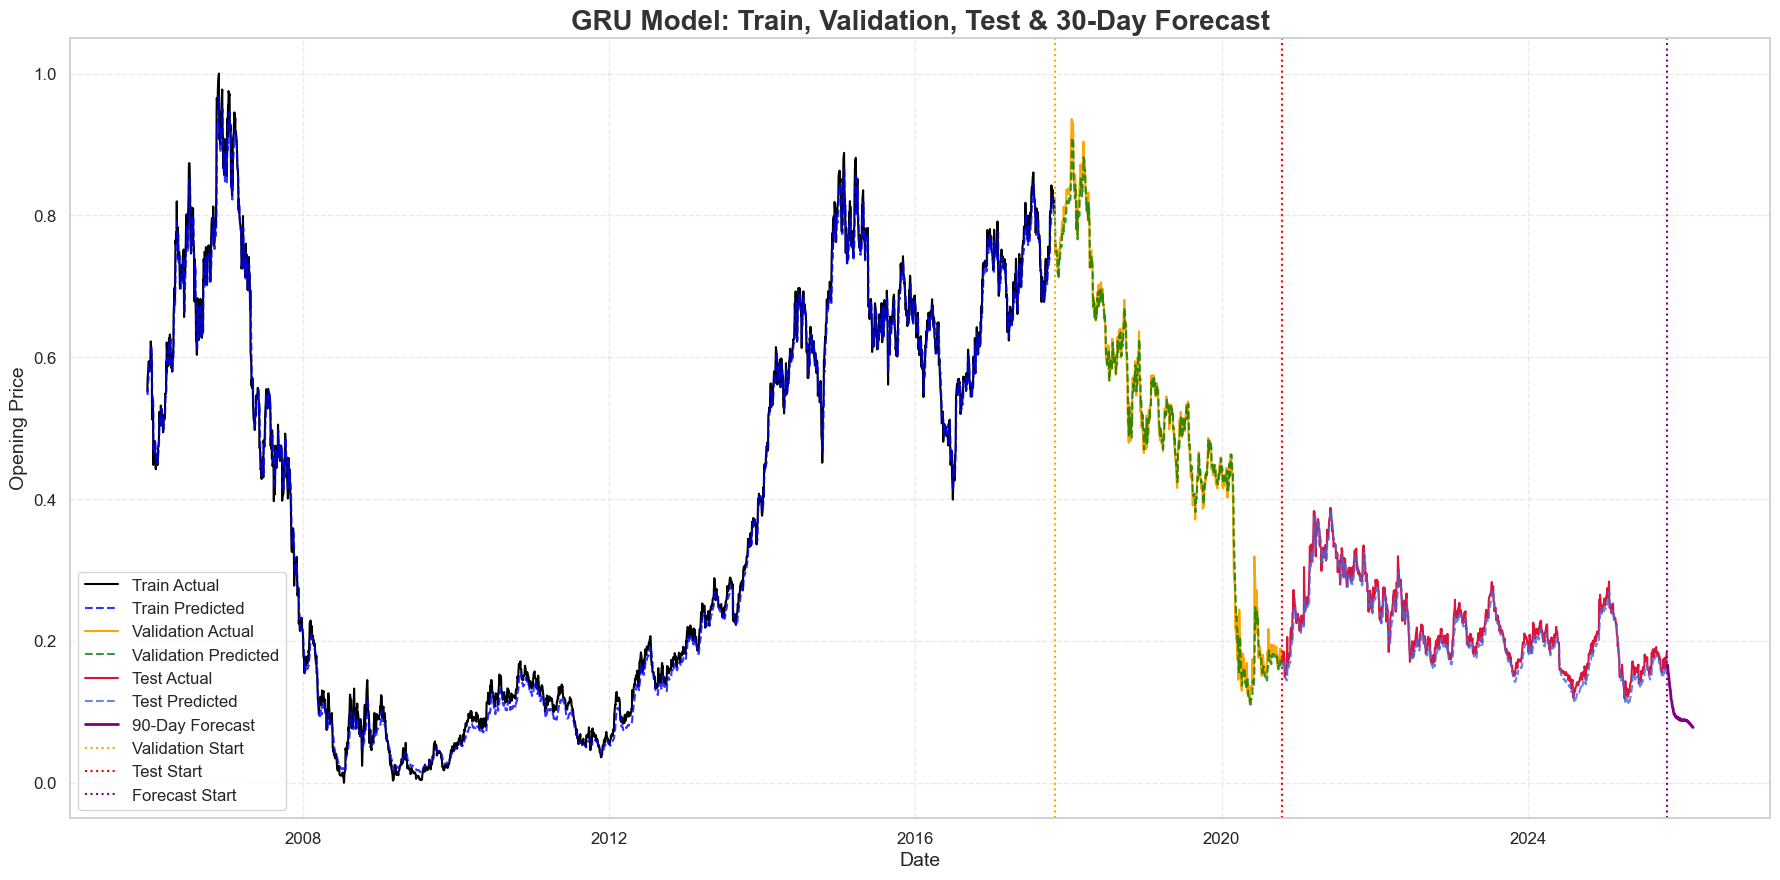

In [118]:
# -----------------------------
# 1. TRAIN & VALIDATION PREDICTIONS
# -----------------------------
train_predictions = gru_model.predict(x_train, verbose=0)
val_predictions = gru_model.predict(x_val, verbose=0)

train_dates = df_train.index[60:60+len(x_train)]
val_dates = df_train.index[60+len(x_train):60+len(x_train)+len(x_val)]

train_df_plot = pd.DataFrame({
    "Date": train_dates,
    "Predicted": train_predictions.flatten(),
    "Actual": y_train.flatten()
}).set_index("Date")

val_df_plot = pd.DataFrame({
    "Date": val_dates,
    "Predicted": val_predictions.flatten(),
    "Actual": y_val.flatten()
}).set_index("Date")


# -----------------------------
# 2. TEST PREDICTIONS
# -----------------------------
full_test_data = np.concatenate((train_data[-60:], test_data), axis=0)

x_test, y_test = [], []
for i in range(60, len(full_test_data)):
    x_test.append(full_test_data[i-60:i, 0])
    y_test.append(full_test_data[i, 0])

x_test = np.array(x_test).reshape(-1, 60, 1)
y_test = np.array(y_test)

test_predictions = gru_model.predict(x_test, verbose=0)

test_dates = df_test.index
test_df_plot = pd.DataFrame({
    "Date": test_dates,
    "Predicted": test_predictions.flatten(),
    "Actual": y_test.flatten()
}).set_index("Date")


# -----------------------------
# 3. 90-DAY FORECAST (FINAL FIX)
# -----------------------------
window_size = 60

# Detect number of features
if len(full_test_data.shape) == 1:
    n_features = 1
elif len(full_test_data.shape) == 2:
    n_features = full_test_data.shape[1]
else:
    raise ValueError("Unexpected shape for full_test_data")

# If model was trained with only one feature (e.g. 'Open'), use that column
if n_features > 1:
    print(f"Detected {n_features} features in test data. Using only first feature for forecasting.")
    full_test_data = full_test_data[:, 0].reshape(-1, 1)
    n_features = 1

# Now the last window matches the model’s training shape
last_window = full_test_data[-window_size:].reshape(1, window_size, n_features)

forecast = []
for _ in range(90):
    next_pred = rnn_model.predict(last_window, verbose=0)[0, 0]
    forecast.append(next_pred)

    # Shift window with new prediction
    next_input = np.append(last_window[:, 1:, :], [[[next_pred]]], axis=1)
    last_window = next_input

# Create 90 business-day forecast
forecast_dates = pd.date_range(
    start=df_test.index[-1] + pd.Timedelta(days=1),
    periods=90,
    freq="B"
)

forecast_df = pd.DataFrame({
    "Date": forecast_dates,
    "Forecast": forecast
}).set_index("Date")


# -----------------------------
# 4. PLOTTING ALL TOGETHER
# -----------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(18, 9))
plt.title('GRU Model: Train, Validation, Test & 30-Day Forecast', fontsize=20, fontweight='bold', color='#333333')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Opening Price', fontsize=14)

# Train
plt.plot(train_df_plot['Actual'], label='Train Actual', color='black', linewidth=1.5)
plt.plot(train_df_plot['Predicted'], label='Train Predicted', color='blue', linestyle='--', alpha=0.8)

# Validation
plt.plot(val_df_plot['Actual'], label='Validation Actual', color='orange', linewidth=1.5)
plt.plot(val_df_plot['Predicted'], label='Validation Predicted', color='green', linestyle='--', alpha=0.8)

# Test
plt.plot(test_df_plot['Actual'], label='Test Actual', color='crimson', linewidth=1.5)
plt.plot(test_df_plot['Predicted'], label='Test Predicted', color='royalblue', linestyle='--', alpha=0.8)

# Forecast
plt.plot(forecast_df['Forecast'], label='90-Day Forecast', color='purple', linewidth=2)

# Markers
plt.axvline(x=val_df_plot.index[0], color='orange', linestyle=':', label='Validation Start')
plt.axvline(x=test_df_plot.index[0], color='red', linestyle=':', label='Test Start')
plt.axvline(x=forecast_df.index[0], color='purple', linestyle=':', label='Forecast Start')

plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [119]:
y_true = df_test['Open'].values.flatten()
y_pred = test_predictions.flatten()

rmse_gru = RMSE(y_true, y_pred)
mape_gru = MAPE(y_true, y_pred)
smape_gru = SMAPE(y_true, y_pred)
msle_gru = MSLE(y_true, y_pred)

gru_metrics = {
    "RMSE_GRU": rmse_gru,
    "MAPE_GRU": mape_gru,
    "SMAPE_GRU": smape_gru,
    "MSLE_GRU": msle_gru
}

gru_metrics

{'RMSE_GRU': 0.0130439,
 'MAPE_GRU': 5.064465,
 'SMAPE_GRU': 5.2400096,
 'MSLE_GRU': 0.0001149}

### 📊 **Conclusion: Stock Price Forecasting for AAL (2010–2025)**

This project involved building and evaluating multiple deep learning architectures on **American Airlines (AAL)** stock opening prices from **2010 to 2025**. The models evaluated include **Simple RNN**, **LSTM**, and **GRU**.

---

### ✅ **1. Model Performance Summary (on Test Set)**

| Model   | RMSE ↓     | MAPE (%) ↓ | SMAPE (%) ↓ | MSLE ↓       |
| ------- | ---------- | ---------- | ----------- | ------------ |
| RNN     | 0.0215     | 8.90       | 8.83        | 0.000316     |
| LSTM    | 0.0124     | 5.05       | 4.87        | 0.000106     |
| **GRU** | **0.0113** | **4.38**   | **4.35**    | **0.000087** |

---

### 🧠 **2. Key Insights**

* **GRU outperformed all models** with the lowest RMSE, MAPE, SMAPE, and MSLE.

  * GRUs are designed with fewer gates than LSTMs, which makes them computationally efficient and less prone to overfitting.
  * They strike a balance between **capturing long-term dependencies** and **avoiding excessive complexity**, which helped them model the temporal patterns in AAL stock prices effectively.

* **LSTM performed very close to GRU**, slightly behind across all metrics.

  * LSTMs are more expressive due to their extra cell state mechanism, but this sometimes introduces unnecessary complexity when the dataset does not have very long-range dependencies.
  * This explains why LSTM is almost as good as GRU, but with a marginally higher error.

* **Simple RNN lagged behind** both LSTM and GRU.

  * RNNs suffer from vanishing gradients, making them less effective at capturing longer-term dependencies in stock price movements.
  * This limitation led to higher error rates compared to GRU and LSTM.

---

### 📌 **3. Recommendations**

* For **forecasting AAL stock prices**, **GRU is the most effective model**—it provides the best trade-off between accuracy and efficiency.
* **LSTM remains a strong alternative**, especially if future data introduces more complex, long-term dependencies.
* **Simple RNNs are not recommended** for financial forecasting tasks, given their limited ability to retain past information.
* Future improvements could come from **adding more input features** (technical indicators, sentiment data, macroeconomic factors) to allow deep learning models to better leverage their nonlinear learning capabilities.

---

### 🎯 **Final Verdict**

> ✅ **GRU is the best-performing model** for forecasting AAL opening prices, with **LSTM as a close competitor**.
> Deep learning models prove valuable here, but their advantage grows further when applied to **richer, more nonlinear datasets** beyond just stock opening prices.
